In [8]:
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, add_messages, END, START
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List
from langgraph.prebuilt import ToolNode

load_dotenv()


True

In [12]:
class ChildState(TypedDict):
    messages:Annotated[List, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return{
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tool_router(state:ChildState):
    last_message = state["messages"][-1]
    print("last_message: ",last_message)
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END

tool_node = ToolNode(tools)

subgraph = StateGraph(ChildState)
subgraph.add_node("agent",agent)
subgraph.add_node("tool_node",tool_node)
subgraph.add_edge("tool_node","agent")
subgraph.add_conditional_edges("agent",tool_router)
subgraph.set_entry_point("agent")

search_app = subgraph.compile()

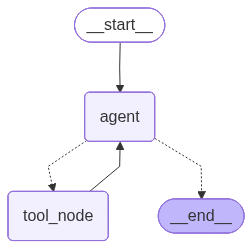

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [ ]:
search_app.invoke({"messages":[HumanMessage(content="How is the weather in bombay?")]})

In [ ]:
# parent and subgraph have the same schema
class ParentState(TypedDict):
    messages : Annotated[List, add_messages]

parent_graph = StateGraph(ParentState)

parent_graph.add_node("search_agent",search_app)
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()
result = parent_app.invoke({"messages":[HumanMessage(content="How is the weather in Mumbai?")]})

In [13]:
# parent and subgraph have different schemas

class QueryState(TypedDict):
    query: str
    response: str

def search_agent(state: QueryState):
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    subgraph_result = search_app.invoke(subgraph_input)
    assistant_message = subgraph_result["messages"][-1]
    return {"response":assistant_message.content}

parent_graph = StateGraph(QueryState)

parent_graph.add_node("search_agent", search_agent)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent",END)

parent_app = parent_graph.compile()

result = parent_app.invoke({"query":"How is the weather in Chennai"})
print(result)

last_message:  content='' additional_kwargs={'tool_calls': [{'id': 'a7yvsq4cm', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 284, 'total_tokens': 306, 'completion_time': 0.042314178, 'prompt_time': 0.029314081, 'queue_time': 0.009599896, 'total_time': 0.071628259}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_6c980774ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-2f6add59-c0dd-40b8-87a0-5eb14b054541-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'a7yvsq4cm', 'type': 'tool_call'}] usage_metadata={'input_tokens': 284, 'output_tokens': 22, 'total_tokens': 306}
last_message:  content='The weather in Chennai is very hot in January with average temperatures ranging from 23°C to 29°C. It may experience a few rainy days, but the weather is usually com